### 测试CUTE和Corrfunc差异

In [1]:
import numpy as np 
import joblib 

In [2]:
root_path = "/Raid6/1/xiaoliang/simulation/BIGMDPL/data/"

In [3]:
tpcf_corr = joblib.load(root_path + "tpCF-11_nbar1e-3.shiftz-nbar1e-3.x8ran0-150s0to150_120mu.pkl")

In [8]:
tpcf_corr["muedges"]

array([0.        , 0.00833333, 0.01666667, 0.025     , 0.03333333,
       0.04166667, 0.05      , 0.05833333, 0.06666667, 0.075     ,
       0.08333333, 0.09166667, 0.1       , 0.10833333, 0.11666667,
       0.125     , 0.13333333, 0.14166667, 0.15      , 0.15833333,
       0.16666667, 0.175     , 0.18333333, 0.19166667, 0.2       ,
       0.20833333, 0.21666667, 0.225     , 0.23333333, 0.24166667,
       0.25      , 0.25833333, 0.26666667, 0.275     , 0.28333333,
       0.29166667, 0.3       , 0.30833333, 0.31666667, 0.325     ,
       0.33333333, 0.34166667, 0.35      , 0.35833333, 0.36666667,
       0.375     , 0.38333333, 0.39166667, 0.4       , 0.40833333,
       0.41666667, 0.425     , 0.43333333, 0.44166667, 0.45      ,
       0.45833333, 0.46666667, 0.475     , 0.48333333, 0.49166667,
       0.5       , 0.50833333, 0.51666667, 0.525     , 0.53333333,
       0.54166667, 0.55      , 0.55833333, 0.56666667, 0.575     ,
       0.58333333, 0.59166667, 0.6       , 0.60833333, 0.61666

### 测试宇宙学转换函数核心速度

In [1]:
import numpy as np 
import math
from LSS_python.base import DA_jit, Hz_jit
from numba import njit 

In [2]:
@njit
def smu_cosmo_convert(s_f, mu_f, DA_f, DA_t, H_f, H_t):
    """s1: angular direction; s2: LOS direction
    f: fiducial; t: task
    """
    s2 = s_f * mu_f
    s1 = s_f * np.sqrt(1 - mu_f**2)
    alpha1 = DA_t / DA_f
    alpha2 = H_f / H_t
    s_t = np.sqrt((alpha1 * s1) ** 2 + (alpha2 * s2) ** 2)
    mu_t = alpha2 * s2 / (s_t + 1e-15)
    return s_t, mu_t

@njit
def smu_cosmo_convert_math(s_f, mu_f, DA_f, DA_t, H_f, H_t):
    """s1: angular direction; s2: LOS direction
    f: fiducial; t: task
    """
    s2 = s_f * mu_f
    s1 = s_f * math.sqrt(1 - mu_f**2)
    alpha1 = DA_t / DA_f
    alpha2 = H_f / H_t
    s_t = math.sqrt((alpha1 * s1) ** 2 + (alpha2 * s2) ** 2)
    mu_t = alpha2 * s2 / (s_t + 1e-15)
    return s_t, mu_t

In [3]:
DA_f = DA_jit(0.6, 0.3071, -1.0)
DA_t = DA_jit(0.6, 0.4071, -0.8)

Hz_f = Hz_jit(0.6, 0.3071, -1.0)
Hz_t = Hz_jit(0.6, 0.4071, -0.8)

In [4]:
s_f, mu_f = 10.0, 0.4
s_t1, mu_t1 = smu_cosmo_convert(s_f, mu_f, DA_f, DA_t, Hz_f, Hz_t)
s_t2, mu_t2 = smu_cosmo_convert_math(s_f, mu_f, DA_f, DA_t, Hz_f, Hz_t)

In [9]:
number = 50000 * 100

s_f_array = np.ones(number) * s_f
mu_f_array = np.ones(number) * mu_f
DA_f_array = np.ones(number) * DA_f
Hz_f_array = np.ones(number) * Hz_f
Hz_t_array = np.ones(number) * Hz_t
DA_t_array = np.ones(number) * DA_t

s_t_array, mu_t_array = smu_cosmo_convert(s_f_array, mu_f_array, DA_f_array, DA_t_array, Hz_f_array, Hz_t_array)

In [10]:
%%timeit -n 3 -r 5
s_t_array, mu_t_array = smu_cosmo_convert(s_f_array, mu_f_array, DA_f_array, DA_t_array, Hz_f_array, Hz_t_array)

181 ms ± 4.96 ms per loop (mean ± std. dev. of 5 runs, 3 loops each)


In [21]:
%%timeit -n 100 -r 5
s_t1, mu_t1 = smu_cosmo_convert(s_f, mu_f, DA_f, DA_t, Hz_f, Hz_t)

1.67 μs ± 102 ns per loop (mean ± std. dev. of 5 runs, 100 loops each)


In [22]:
%%timeit -n 100 -r 5
s_t2, mu_t2 = smu_cosmo_convert_math(s_f, mu_f, DA_f, DA_t, Hz_f, Hz_t)

1.62 μs ± 89 ns per loop (mean ± std. dev. of 5 runs, 100 loops each)


### 测试：积分函数

In [1]:
import numpy as np 
from LSS_python.base import traz 

In [2]:
x_array = np.linspace(0.0, 1*np.pi, 100)
V_array = np.sin(x_array)
print(traz(V_array, x_array))

1.9998321638939927


In [8]:
x_array = np.linspace(0, 2, 10)
y_array = np.linspace(0, 1, 10)
X_mesh, Y_mesh = np.meshgrid(x_array, y_array, indexing="ij")
V_array = X_mesh + Y_mesh
print(traz(V_array, x_array, y_array))

3.0


### 测试：寻找邻居构建MCF

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
from scipy.spatial import KDTree
from sklearn.neighbors import NearestNeighbors
from MCF import cal_rho_array, cal_rho, w_kernel

In [3]:
data = np.load("/Raid6/1b/xiaoliang/simulation/COLA/tpCF/LCDM_plank13_box1000_npar1024/halo_2_shiftz.npy")

In [4]:
boxsize = 1000.0
kdtree = KDTree(data, boxsize=None)
kdtree_result = kdtree.query(data, k=31, distance_upper_bound=30)

In [4]:
kdtree_result[0]

array([[ 0.        , 11.0385601 , 12.44208462, ...,         inf,
                inf,         inf],
       [ 0.        ,  1.27633405,  2.44308663, ...,         inf,
                inf,         inf],
       [ 0.        ,  1.20811361,  1.27633405, ...,         inf,
                inf,         inf],
       ...,
       [ 0.        ,  2.32409592,  5.57591046, ..., 22.79207145,
        22.98082245, 23.09866202],
       [ 0.        ,  1.25566053,  7.13560577, ..., 15.47875454,
        15.74954147, 16.18373074],
       [ 0.        ,  1.25566053,  8.35197004, ..., 16.2688897 ,
        16.5664349 , 16.59623687]])

In [5]:
rho_array_1 = cal_rho_array(kdtree_result[0], 15.0)

In [5]:
new_result = np.copy(kdtree_result[0])
new_result[np.isinf(new_result)] = 0.0

In [6]:
rho_array_2 = cal_rho_array(new_result, h=None, use_max_distance_as_h=True)

In [8]:
np.max(rho_array_1)

0.002806452408888902

In [7]:
np.max(rho_array_2)

3.2178659891309183

In [8]:
np.argmax(rho_array_2)

527616

In [9]:
test_array = new_result[527616]
h = np.max(test_array) / 2.0
for item in test_array:
    print(w_kernel(item, h))

0.0
0.3386353950755209
0.3276987994066367
0.30465644441320033
0.27292384163002437
0.22617299132301488
0.22005924137780372
0.2028193195489765
0.1987792646181191
0.1799662197018824
0.15286360534886936
0.13533156064922777
0.1254683527341903
0.12380026309021663
0.10296749511496255
0.0999797277384586
0.0697083485773174
0.05876485568716877
0.04682078416170166
0.010457570083572053
0.00575565456838483
0.004941321217487585
0.004801925395647695
0.0026567149879603274
0.0006907715979496981
0.0005856160990220412
0.0005515034918893084
4.022925496806105e-06
3.005811867078159e-06
1.3727543482606666e-06
0.0


In [10]:
new_result[527616]

array([0.        , 0.49785289, 0.51504562, 0.55103379, 0.60054181,
       0.674938  , 0.68492568, 0.71357819, 0.72041416, 0.75300284,
       0.8028623 , 0.83777844, 0.85871537, 0.86236371, 0.91096991,
       0.91846471, 1.00453267, 1.04181623, 1.08824296, 1.32029562,
       1.38491271, 1.39945881, 1.40210598, 1.45156323, 1.53358566,
       1.54133697, 1.54404988, 1.65226881, 1.65467946, 1.66011142,
       1.67830634])

### 测试：B样条插值函数性质

In [11]:
from MCF import w_kernel
from base import traz
import numpy as np
import matplotlib.pyplot as plt

In [12]:
x = np.linspace(0,10,1000)
y = np.zeros(1000)

for i in range(1000):
    y[i] = w_kernel(x[i], 5.0)

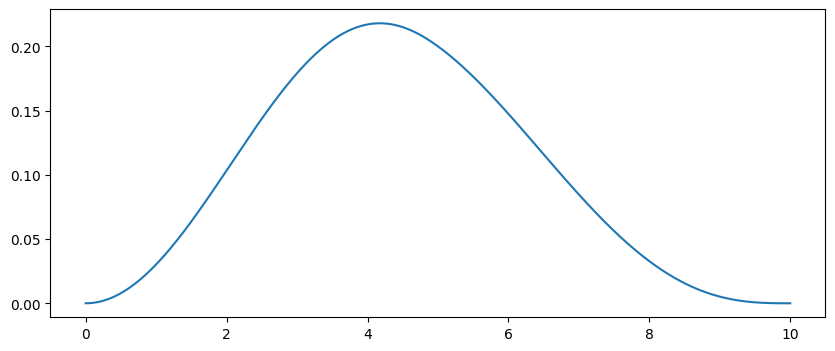

In [36]:
fig = plt.figure(dpi=100, figsize=(10,4))
plt.plot(x,y*4*np.pi*x**2)
plt.show()

In [9]:
traz(y * 4 * np.pi * x**2, x)

1.000000000001004

In [2]:
from MCF import cal_rho_array
import numpy as np 

In [15]:
distance_array = np.array([[1.0, 2.0, 4.0, 6.0, 10.0, 15.0, 25.0]*3, 
                            [0.1, 0.2, 3.0, 5.0, 8.0, 10.0, 25.0]*3])

In [16]:
test1 = cal_rho_array(distance_array, 15.0)
print(test1)
print(test1[0] / test1[1])

[0.00127297 0.00143132]
0.8893652448971467


In [17]:
test2 = cal_rho_array(distance_array, 15.0, True)
print(test2)
print(test2[0] / test2[1])

[0.0020123  0.00231637]
0.8687288077734915


### 测试：和霄栋程序比对

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial import KDTree
from MCF import cal_rho_array

In [2]:
data = np.loadtxt("/Raid6/1/xiaoliang/AP_SysTest/no_error/11/11_nbar1e-3.shiftz.numNB30.margin30.00.boxsize2500.00", usecols=(0,1,2,3, 7), dtype=np.float32)

In [3]:
kdtree = KDTree(data[:,:3], boxsize=2500.00001)

In [4]:
result = kdtree.query(data[:,:3], k=30, workers=4)

In [24]:
rho_array_1 = cal_rho_array(result[0], h=15.0)

In [5]:
rho_array_2 = cal_rho_array(result[0], h=None, use_max_distance_as_h=True)

In [11]:
rho_diff = np.abs(rho_array_2 - data[:,3]) / data[:,3]

In [14]:
rho_array_2[11635385], data[11635385]

(0.006944564999304728,
 array([1.649590e+03, 1.807200e+03, 1.036378e+03, 4.613864e-03,
        1.708199e+01], dtype=float32))

In [16]:
result[0][11635385]

array([ 0.        ,  0.69110607,  1.48557591,  1.53849273,  3.72670703,
        4.45531767,  5.54754204,  5.70324914,  6.3145058 ,  7.19396082,
        7.3161547 ,  9.32262483,  9.3792178 ,  9.8703873 , 10.07878728,
       10.1284821 , 10.1397247 , 10.23131817, 11.00803391, 11.23779393,
       11.63617197, 11.90615272, 11.92339883, 12.33899976, 12.95179811,
       13.19823147, 13.25885542, 13.35740821, 13.42721398, 13.68411764])

In [18]:
result[1][11635385]

array([11635385,  4842161, 12019953, 15117531,  1464956, 11026159,
        5250874, 12717999, 12558578,  8339432,  2680504,  1763902,
        1458581,  8707740,  5075076,  4442086,  4080292,  9986510,
        3275667,  2031194,  9754804, 11956876,  1679109,  5352734,
        1606091,  1615725,  3843949,  5636992, 10285211,   173500])

In [25]:
result[0][6]

array([ 0.        ,  0.99441016,  2.28165814,  3.98553596,  4.13906364,
        4.51890682,  4.63917141,  5.60877648,  6.00639044,  6.21201024,
        6.32884083,  6.72885667,  6.75337787,  6.8314492 ,  7.6610031 ,
        8.10814599,  8.41088346,  8.48868327,  8.85338081,  9.1335584 ,
        9.37975213,  9.81318022, 10.03043017, 10.27811091, 10.34872493,
       10.36183734, 10.60363012, 10.6055239 , 10.88957277, 11.19794649])

In [19]:
result[1][4]

array([       4, 14595535, 12952946,   912174,  7434422,  8754480,
        7002900,  4879280,  1073795,  3511809, 14114663,  7726609,
         886193,   383362,  3096251, 13622008,  3827284,  7766690,
        6312866, 14836290,  6995536, 10764836, 11712761, 11919745,
       12159220,  3809302,  9801393,  3012254,  5710999,  6415659])

In [52]:
def cal_distance(data, index_array):
    distance_array = np.zeros(index_array.shape, dtype=np.float32)
    fuducial_pos = data[index_array[0]]
    for i in range(index_array.shape[0]):
        distance_temp = 0.0 
        for j in range(3):
            pos_diff = data[index_array[i]][j] - fuducial_pos[j]
            distance_temp += pos_diff * pos_diff
        distance_array[i] = np.sqrt(distance_temp)
    return distance_array

In [53]:
cal_distance(data[:,:3], result[1][0])

array([ 0.       ,  1.5781667,  2.3395114,  3.1305943,  3.525681 ,
        3.7073488,  3.8607461,  4.4709334,  6.526491 ,  6.6373944,
        6.830204 ,  7.0865097,  8.398026 ,  8.7853565,  9.939289 ,
       10.367059 , 11.337845 , 11.499579 , 12.129817 , 12.201879 ,
       12.232749 , 12.393038 , 12.41142  , 13.00485  , 13.273669 ,
       13.304365 , 13.345138 , 13.777317 , 13.835587 , 14.184428 ,
       14.376134 ], dtype=float32)

### 测试：加权关联函数对比

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from LSS_python.tpcf import xismu 

In [2]:
root_path = "/Raid6/1/xiaoliang/AP_SysTest/no_error/"
tpcf_CUTE_filenames = [root_path + "11/11_nbar1e-3.shiftz.numNB30.margin30.00.boxsize2500.00-zplus1000000-weipow1-150s0to150-120mu.2pcf", root_path + "26/26_nbar1e-3.shiftz.numNB30.margin30.00.boxsize2500.00-zplus1000000-weipow1-150s0to150-120mu.2pcf"]
tpcf_pkl_filename = [root_path + "11/tpCF-11_nbar1e-3.shiftz.numNB30-weipow1-150s0to150-120mu.pkl", root_path + "26/tpCF-26_nbar1e-3.shiftz.numNB30-weipow1-150s0to150-120mu.pkl"]
tpcf_CUTE_list = [xismu.load(tpcf_CUTE_filenames[i]) for i in range(2)]
tpcf_pkl_list = [xismu.load(tpcf_pkl_filename[i], data_type="BINARY") for i in range(2)]

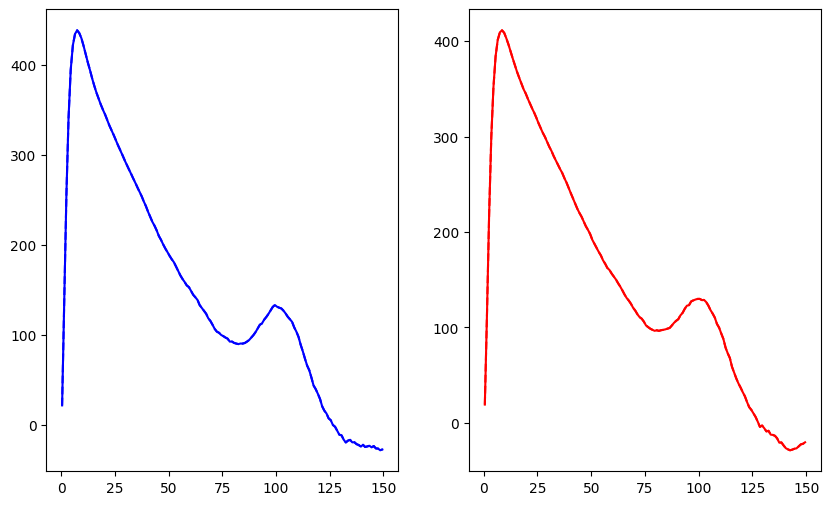

In [4]:
fig = plt.figure(dpi=100, figsize=(10, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax1, ax2]
colors = ["blue", "red"]
for i in range(2):
    s_CUTE, xis_s_CUTE = tpcf_CUTE_list[i].integrate_tpcf(smin=0.0, smax=150.0, s_xis=True, intximu=False, quick_return=True)
    s_pkl, xis_s_pkl = tpcf_pkl_list[i].integrate_tpcf(smin=0.0, smax=150.0, s_xis=True, intximu=False, quick_return=True)
    axes[i].plot(s_CUTE, xis_s_CUTE, color=colors[i])
    axes[i].plot(s_pkl, xis_s_pkl, color=colors[i], ls="--")
plt.show()

In [13]:
tpcf_pkl_list[0].S

array([[  0.5,   0.5,   0.5, ...,   0.5,   0.5,   0.5],
       [  1.5,   1.5,   1.5, ...,   1.5,   1.5,   1.5],
       [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
       ...,
       [147.5, 147.5, 147.5, ..., 147.5, 147.5, 147.5],
       [148.5, 148.5, 148.5, ..., 148.5, 148.5, 148.5],
       [149.5, 149.5, 149.5, ..., 149.5, 149.5, 149.5]])

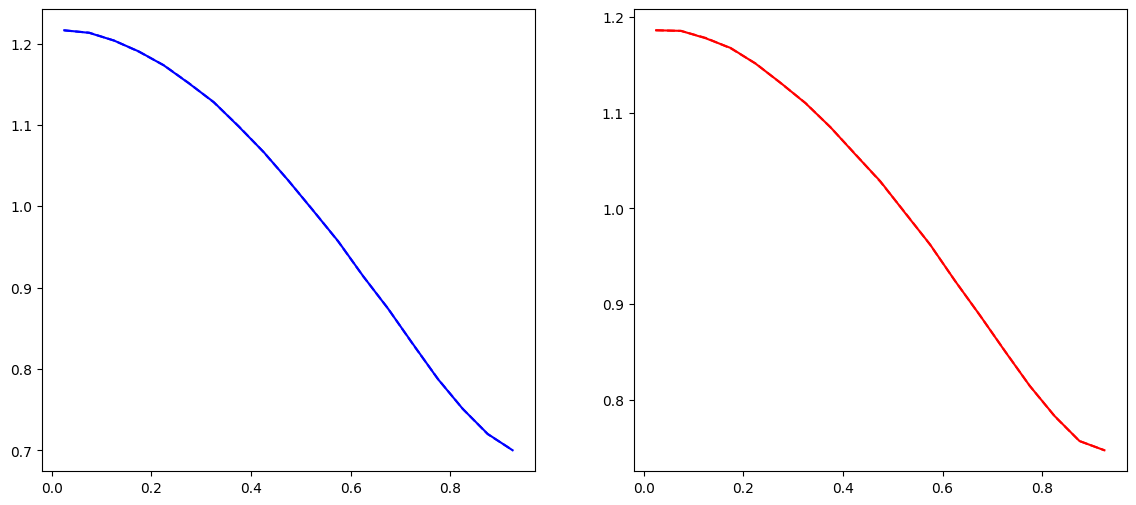

In [6]:
fig = plt.figure(dpi=100, figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax1, ax2]
colors = ["blue", "red"]
for i in range(2):
    mu_CUTE, xis_mu_CUTE = tpcf_CUTE_list[i].integrate_tpcf(mupack=6, is_norm=True, quick_return=True)
    mu_pkl, xis_mu_pkl = tpcf_pkl_list[i].integrate_tpcf(mupack=6, is_norm=True, quick_return=True)
    axes[i].plot(mu_CUTE, xis_mu_CUTE, color=colors[i])
    axes[i].plot(mu_pkl, xis_mu_pkl, color=colors[i], ls="--")
plt.show()

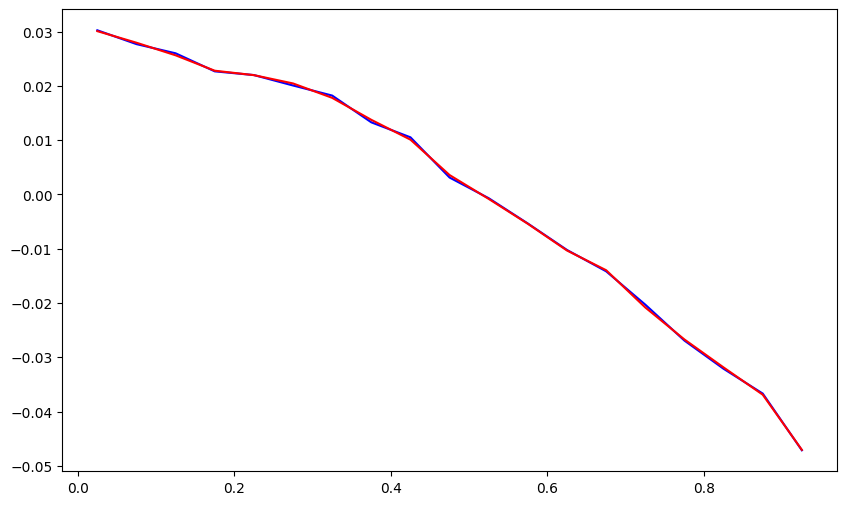

In [7]:
fig = plt.figure(dpi=100, figsize=(10, 6))
ax = fig.add_subplot(111)
axes = [ax1, ax2]
colors = ["blue", "red"]
xis_mu_CUTE_list = []
xis_mu_pkl_list = []
for i in range(2):
    mu_CUTE, xis_mu_CUTE = tpcf_CUTE_list[i].integrate_tpcf(mupack=6, is_norm=True, quick_return=True)
    mu_pkl, xis_mu_pkl = tpcf_pkl_list[i].integrate_tpcf(mupack=6, is_norm=True, quick_return=True)
    xis_mu_CUTE_list.append(xis_mu_CUTE)
    xis_mu_pkl_list.append(xis_mu_pkl)
ax.plot(mu_CUTE, xis_mu_CUTE_list[0] - xis_mu_CUTE_list[1], color=colors[0])
ax.plot(mu_pkl, xis_mu_pkl_list[0] - xis_mu_pkl_list[1], color=colors[1])
plt.show()

### 测试：numba的FFTPower 

In [1]:
import numpy as np 

from my_fft import FFTPower as FFTPower_old
from LSS_python.fftpower import FFTPower, deal_ps_3d

In [2]:
complex_field = np.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/mass_fftpower_mesh1024_all_complex/complex_field.npy")
kernel_field = np.load("/Raid6/1/xiaoliang/simulation/ska/data/mesh1024_all_complex_kernel1/complex_field.npy")
Nmesh = 1024 
boxsize = 1000.0 

In [7]:
complex_field_temp = np.copy(complex_field)
ps_3d = np.copy(complex_field)

In [4]:
complex_field_temp_kernel = complex_field_temp * kernel_field
fftpower_old = FFTPower_old(Nmesh, boxsize, shotnoise=0.0)
complex_field_temp_kernel = complex_field_temp_kernel * np.conj(complex_field_temp_kernel) * np.prod(fftpower_old.attrs["BoxSize"])
fftpower_old.is_run_ps_3d = True
_ = fftpower_old.run(complex_field_temp_kernel, 0.1, 3.1, 0.01, 50, mode="2d", run_ps_3d=False, nthreads=10)

In [8]:
fftpower_new = FFTPower(Nmesh, boxsize, shotnoise=0.0)
deal_ps_3d(ps_3d, ps_3d_kernel=kernel_field, ps_3d_factor=np.prod(fftpower_new.attrs["BoxSize"]), shotnoise=fftpower_new.attrs["shotnoise"], nthreads=10)
_ = fftpower_new.run(ps_3d, 0.1, 3.1, 0.01, 50, mode="2d", nthreads=10)

In [6]:
np.nansum(np.abs(fftpower_old.power["Pkmu"] - fftpower_new.power["Pkmu"]))

np.float64(4.057218621356175e-06)

### 测试：numba和cuda版本的FFTPower 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import cupy as cp 

from LSS_python.fftpower import FFTPower, deal_ps_3d
from LSS_python.cuda.fftpower import get_deal_ps_core_kernel, get_run_fftpower_core_kernel

In [3]:
complex_field = np.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/mass_fftpower_mesh1024_all_complex/complex_field.npy")
ps_3d_cpu = np.copy(complex_field)
ps_3d_gpu = cp.asarray(ps_3d_cpu)

In [4]:
fftpower_cpu = FFTPower(1024, 1000.0, 0.0)
deal_ps_3d(ps_3d_cpu, None, 1000.0**3, 0.0, nthreads=10)

In [5]:
_ = fftpower_cpu.run(
    ps_3d_cpu, 0.1, 3.1, 0.01, Nmu=50, mode="2d", linear=True, nthreads=10
)

In [6]:
%%timeit -n 5 -r 5 
_ = fftpower_cpu.run(
    ps_3d_cpu, 0.1, 3.1, 0.01, Nmu=50, mode="2d", linear=True, nthreads=10
)

1.29 s ± 8.87 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [6]:
deal_ps_core_kernel = get_deal_ps_core_kernel()
deal_ps_core_kernel.compile()
run_fftpower_core_kernel = get_run_fftpower_core_kernel()
run_fftpower_core_kernel.compile()

In [7]:
fftpower_gpu = FFTPower(1024, 1000.0, 0.0)
nx, ny, nz = ps_3d_gpu.shape
ps_3d_kernel_gpu = cp.array([0], dtype=cp.complex64)
deal_ps_core_kernel((nx,ny), (nz,), (ps_3d_gpu, ps_3d_kernel_gpu, nx, ny, nz, 1000.0**3, 0.0, False))
fftpower_gpu.run_from_cuda(
    run_fftpower_core_kernel,
    ps_3d_gpu,
    0.1, 3.1, 0.01, Nmu=50, mode="2d"
)
cp.cuda.Stream.null.synchronize()

In [15]:
%%timeit -n 5 -r 5 
fftpower_gpu.run_from_cuda(
    run_fftpower_core_kernel,
    ps_3d_gpu,
    0.1, 3.1, 0.01, Nmu=50, mode="2d"
)

count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
114 ms ± 42.7 μs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [12]:
np.nanargmax(np.abs(fftpower_cpu.power["Pkmu"] - fftpower_gpu.power["Pkmu"]))

np.int64(116)

In [16]:
fftpower_cpu.power["modes"][2, 16]

np.uint64(20)

In [15]:
fftpower_gpu.power["modes"][2, 16]

np.uint32(32)

In [6]:
fftpower_cpu.power["modes"][2]

array([216,   0, 432,   0, 184, 224,   0, 408,   0, 208, 216,   0, 360,
        32, 184, 192,  32, 288, 104, 176, 200,  72, 216, 128, 184, 192,
       128, 208, 136, 176, 144, 176, 160, 168, 160, 128, 216, 152, 208,
       168, 104, 216,  96, 208, 144, 112, 232, 112, 184, 170],
      dtype=uint64)

In [9]:
fftpower_gpu.power["modes"][2]

array([216,   0, 432,   0, 184, 224,   0, 408,   0, 208, 216,   0, 360,
        32, 184, 192,  32, 288, 104, 176, 200,  72, 216, 128, 184, 192,
       128, 208, 136, 176, 144, 176, 160, 168, 160, 128, 216, 152, 208,
       168, 104, 216,  96, 208, 144, 112, 232, 112, 184, 170],
      dtype=uint32)

In [19]:
fftpower_cpu.power["modes"][3]

array([133,   0, 266,   0, 278,   0, 144, 142,   0, 234,   0, 246,  28,
       162, 112,  64, 194,   0, 304, 128, 208, 216, 120, 256, 112, 208,
       120, 224, 208, 168, 192, 224, 184, 168, 160, 168, 216, 144, 224,
       168, 240, 152, 168, 184, 144, 232, 112, 232, 160, 196],
      dtype=uint64)

In [20]:
fftpower_gpu.power["modes"][3]

array([212,   0, 424,   0, 440,   0, 216, 224,   0, 368,   0, 384,  48,
       256, 184, 104, 304,   0, 304, 128, 208, 216, 120, 256, 112, 208,
       120, 224, 208, 168, 192, 224, 184, 168, 160, 168, 216, 144, 224,
       168, 240, 152, 168, 184, 144, 232, 112, 232, 160, 196],
      dtype=uint32)

### 测试：ps_convert_main的CPU和GPU功能

In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import cupy as cp 

from LSS_python.AP import ps_convert_main
from LSS_python.fftpower import deal_ps_3d

In [2]:
device_id = 1
use_kernel = False 
complex_field = np.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/mass_fftpower_mesh1024_all_complex/complex_field.npy")
# kernel_field = np.load("/Raid6/1/xiaoliang/simulation/ska/data/mesh1024_all_complex_kernel1/complex_field.npy")
ps_3d_cpu = np.copy(complex_field)
# ps_kernel_3d_cpu = np.copy(kernel_field)
with cp.cuda.Device(device_id):
    ps_3d_gpu = cp.asarray(ps_3d_cpu, dtype=cp.complex64)
    # ps_kernel_3d_gpu = cp.asarray(ps_kernel_3d_cpu)
if not use_kernel:
    ps_kernel_3d_cpu = None 
    ps_kernel_3d_gpu = None

In [7]:
deal_ps_3d(ps_3d_cpu, ps_kernel_3d_cpu, 1000.0**3, 0.0, nthreads=10)
fftpower_cpu = ps_convert_main(ps_3d_cpu, 0.3111, -1.0, 0.25, -1.4, 0.5, boxsize=1000.0, Nmesh=1024, k_min=0.1, k_max = 3.1, dk = 0.01, Nmu = 50, mode="2d", nthreads=10)

In [3]:
deal_ps_3d(ps_3d_gpu, ps_kernel_3d_gpu, 1000.0**3, 0.0, device_id=device_id)

fftpower_gpu = ps_convert_main(ps_3d_gpu, 0.3111, -1.0, 0.25, -1.4, 0.5, boxsize=1000.0, Nmesh=1024, k_min=0.1, k_max = 3.1, dk = 0.01, Nmu = 50, mode="2d", device_id=device_id)

cp.cuda.Stream.null.synchronize()

299 50
k = 0.392, mu = 0.556, mode = 2; ps_3d[iz + iy * nz + ix * nz * ny].x = 0.281, ps_3d[iz + iy * nz + ix * nz * ny].y = 0.000; Pkmu[mu_i + k_i * nmu].x = 98.943, Pkmu[mu_i + k_i * nmu].y = 0.000


In [4]:
fftpower_gpu.power["Pkmu"]

array([[ 944.9220058  +0.j,           nan+nanj, 1016.7768586  +0.j, ...,
        1982.19011966 +0.j, 1720.64753705 +0.j, 1829.79529282 +0.j],
       [ 758.7239509  +0.j,           nan+nanj,  970.50792041 +0.j, ...,
        2084.9974712  +0.j, 1906.20202508 +0.j, 1530.60508345 +0.j],
       [ 697.67026708 +0.j,           nan+nanj,  754.75024028 +0.j, ...,
        1551.873876   +0.j, 1518.94855729 +0.j, 1830.73136424 +0.j],
       ...,
       [  11.77361042 +0.j,   10.93306062 +0.j,    9.71417655 +0.j, ...,
                  nan+nanj,           nan+nanj,           nan+nanj],
       [  11.70952303 +0.j,   10.79973882 +0.j,    9.66516551 +0.j, ...,
                  nan+nanj,           nan+nanj,           nan+nanj],
       [  11.75955145 +0.j,   10.77957275 +0.j,    9.67122997 +0.j, ...,
                  nan+nanj,           nan+nanj,           nan+nanj]])

In [5]:
ps_3d_gpu[0,0,:10]

array([4.8648653e+05+0.j, 5.2095341e+01+0.j, 3.6637869e+00+0.j,
       2.7736778e+00+0.j, 2.3418751e+00+0.j, 4.9966927e+01+0.j,
       1.0812568e+01+0.j, 3.3131866e+01+0.j, 6.9260559e+00+0.j,
       7.7926393e+00+0.j], dtype=complex64)

In [8]:
ps_3d_cpu[0,0,:10]

array([4.8648653e+05+0.j, 5.2095341e+01+0.j, 3.6637866e+00+0.j,
       2.7736778e+00+0.j, 2.3418751e+00+0.j, 4.9966923e+01+0.j,
       1.0812567e+01+0.j, 3.3131870e+01+0.j, 6.9260559e+00+0.j,
       7.7926393e+00+0.j], dtype=complex64)

In [12]:
power_modes = fftpower_gpu.power["modes"]
need_index = np.logical_not(power_modes == 0)
fftpower_gpu.power["Pkmu"][need_index]

array([nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj])

In [13]:
fftpower_gpu.power["Pkmu"]

array([[nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       ...,
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj]])

In [10]:
fftpower_cpu.power["modes"][-10]

array([ 98140,  96344,  97640,  98656,  99944, 102352, 105072, 108888,
       116480, 124588, 125120, 125176, 125480, 124968, 124672, 125224,
       125552, 124960, 125312, 125544, 125512, 125080, 125320, 124904,
       125064, 125336, 125240, 124984, 124992, 125304, 125176, 125048,
       125504, 124648, 125216, 125448, 125120, 125072, 125192, 124992,
       124888, 125656, 124928, 125112, 125064, 125400,  60224,      0,
            0,      0], dtype=uint64)

In [5]:
np.nansum(np.abs(fftpower_cpu.power["modes"] - cp.asnumpy(fftpower_gpu.power["modes"])))

np.uint64(0)

### 测试：numba版本的run_cic函数

In [1]:
import numpy as np 
from numba import njit 
from LSS_python.mesh import run_cic

from my_fft import Mesh 

In [2]:
pos = np.load("/Raid6/1/xiaoliang/AP_SysTest/data/11_nbar1e-3.shiftz.numNB30.npy")[:,:3]
struct_pos = np.empty(pos.shape[0], dtype=np.dtype([("Position", "float32", 3)]))
struct_pos["Position"] = pos

In [8]:
mesh = Mesh(256, 2500.0)
real_field = mesh.run_cic(struct_pos, field_dtype=np.float32, nthreads=10)

In [9]:
real_field_numba = np.zeros((256, 256, 256), dtype=np.float32)
run_cic(pos, real_field_numba, np.array([2500.0] * 3), np.array([256]*3, dtype=np.int64))

In [5]:
real_field_numba[0,0]

array([126.94786 , 129.86403 , 150.2515  , 190.74274 , 143.54372 ,
       115.67989 ,  70.903656,  81.55252 ,  96.41311 ,  59.35935 ,
        60.87677 , 188.61066 , 107.72917 ,  86.72349 , 106.56098 ,
       172.04427 , 239.21622 , 173.68716 ,  83.22322 , 138.33684 ,
       138.63982 , 118.98805 , 123.8032  , 110.22647 , 145.77559 ,
       164.63188 ,  85.77486 , 109.25189 , 144.78152 , 131.37888 ,
       128.7141  , 110.37267 ,  79.21247 ,  69.26166 ,  93.65241 ,
        75.967575, 126.4091  , 215.97528 , 250.51453 , 196.19948 ,
        88.78135 , 101.352585, 129.88208 , 160.151   ,  73.57452 ,
        88.40904 , 135.4199  ,  87.44953 , 108.483505, 120.393265],
      dtype=float32)

In [10]:
np.mean(np.abs(real_field - real_field_numba))

np.float32(3.7665975e-06)

### 测试：cuda版本的CIC

In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np 
import cupy as cp 
from LSS_python.mesh import run_cic, run_cic_from_cuda

In [2]:
pos = np.load("/Raid6/1/xiaoliang/AP_SysTest/data/11_nbar1e-3.shiftz.numNB30.npy")[:,:3].astype(np.float32)

In [5]:
Nmesh = 256
real_field_numba = np.zeros((Nmesh, Nmesh, Nmesh), dtype=np.float32)
run_cic(pos, real_field_numba, np.array([2500.0] * 3), np.array([Nmesh]*3, dtype=np.int64))

In [3]:
Nmesh = 256
real_field = run_cic_from_cuda(cp.asarray(pos, dtype=cp.float32), cp.array([2500.0] * 3, dtype=cp.float64), cp.array([Nmesh]*3, dtype=cp.int32))
cp.cuda.Device().synchronize()

In [7]:
np.argmax(np.abs(cp.asnumpy(real_field) - real_field_numba))

np.int64(782174)

In [8]:
need_index = np.unravel_index(782174, shape=real_field.shape) 
print(real_field[need_index])
print(real_field_numba[need_index])

15.556963
15.556966


In [5]:
pos.dtype

dtype('float64')

### 测试：CIC多线程版本

In [3]:
import numpy as np 
from LSS_python.mesh import run_cic_single
import cupy as cp 

In [4]:
pos = np.copy(np.load("/DataGpu01/xiaoliang/snap100_shiftz.npy", mmap_mode="r")["Position"].astype(np.float32))

In [6]:
pos.shape

(519361057, 3)

In [7]:
pos.strides

(12, 4)

In [5]:
Nmesh = 1024
real_field_numba_single = np.zeros((Nmesh, Nmesh, Nmesh), dtype=np.float32)
run_cic_single(pos, None, real_field_numba_single, np.array([2500.0] * 3), np.array([Nmesh]*3, dtype=np.int64))

In [4]:
Nmesh = 1024
real_field_numba_multithreads = np.zeros((Nmesh, Nmesh, Nmesh), dtype=np.float32)
run_cic_multithreads(pos, real_field_numba_multithreads, np.array([2500.0] * 3), np.array([Nmesh]*3, dtype=np.int64), nthreads=5)

In [3]:
Nmesh = 1024 
real_field_cuda = cp.zeros((Nmesh, Nmesh, Nmesh), dtype=cp.float32)
chuck_size = int(2e+7)
chuck_items = pos.shape[0] // chuck_size + 1

for i in range(chuck_items):
    start = i * chuck_size
    end = min(pos.shape[0], start + chuck_size)
    run_cic_from_cuda(cp.asarray(pos[start:end], dtype=cp.float32), real_field_cuda, cp.array([2500.0] * 3, dtype=cp.float64), cp.array([Nmesh]*3, dtype=cp.int32))

In [18]:
real_field_numba_multithreads[0,:10,5]

array([5.4258566e-02, 4.6190135e-03, 2.0381501e-03, 8.8480324e-01,
       4.5497332e+00, 8.5852489e+00, 1.0047110e+01, 2.2590340e+01,
       9.3456907e+00, 2.6121752e+00], dtype=float32)

In [19]:
real_field_numba_single[0,:10,5]

array([5.4258566e-02, 4.6190135e-03, 2.0381501e-03, 8.8480324e-01,
       4.5497332e+00, 8.5852489e+00, 1.0047110e+01, 2.2590340e+01,
       9.3456907e+00, 2.6121752e+00], dtype=float32)

In [ ]:
real_field_cuda[0,:10,5]

array([5.4258574e-02, 4.6190135e-03, 2.0381492e-03, 8.8480312e-01,
       4.5497327e+00, 8.5852489e+00, 1.0047111e+01, 2.2590343e+01,
       9.3456917e+00, 2.6121747e+00], dtype=float32)

In [5]:
np.argmax(np.abs(real_field_numba_single - cp.asnumpy(real_field_cuda)))

NameError: name 'real_field_numba_single' is not defined

In [21]:
need_index = np.unravel_index(16919806, shape=real_field_numba_single.shape)
print(need_index, real_field_numba_single[need_index], real_field_cuda[need_index])

(np.int64(16), np.int64(139), np.int64(254)) 300.89203 300.89188


In [4]:
cp.sum(real_field_cuda)

array(5.1936102e+08, dtype=float32)

In [18]:
np.sum(real_field_numba_multithreads)

np.float32(519363000.0)

In [17]:
pos.shape

(519361057, 3)

### 测试：替代my_fft

In [1]:
import numpy as np 
import cupy as cp 
import matplotlib.pyplot as plt 

from my_fft import Mesh, FFTPower
from LSS_python.mesh import Mesh as Mesh_LSS 
from LSS_python.fftpower import FFTPower as FFTPower_LSS

In [2]:
device_id = 1

pos = np.load("/Raid6/1/xiaoliang/AP_SysTest/data/11_nbar1e-3.shiftz.numNB30.npy")[:,:3].astype(np.float32)
pos_old = np.empty(shape=pos.shape[0], dtype=np.dtype([("Position", "f4", 3)]))
pos_old["Position"] = pos
pos_cpu = np.copy(pos)
with cp.cuda.Device(device_id):
    pos_gpu = cp.asarray(pos, dtype=cp.float32)

Nmesh = 256
boxSize = 2500.0 

In [3]:
mesh_old = Mesh(Nmesh, boxSize)
real_field = mesh_old.run_cic(pos_old, nthreads=5)

In [4]:
mesh_new_cpu = Mesh_LSS(Nmesh, boxSize)
mesh_new_cpu.run_cic(pos_cpu, nthreads=5)

In [5]:
mesh_new_gpu = Mesh_LSS(Nmesh, boxSize)
mesh_new_gpu.run_cic(pos_gpu, device_id=device_id)

In [6]:
np.max(np.abs(mesh_new_cpu.real_field - mesh_old.real_field))

np.float32(6.67572e-06)

In [7]:
np.max(np.abs(mesh_old.real_field - cp.asnumpy(mesh_new_gpu.real_field_gpu)))

np.float32(5.722046e-06)

In [8]:
complex_field = mesh_old.r2c(real_field, compensated=False)

In [9]:
mesh_new_cpu.r2c(compensated=False)

In [10]:
mesh_new_gpu.r2c(compensated=False, device_id=device_id)

In [11]:
np.max(np.abs(mesh_new_cpu.complex_field - mesh_old.complex_field))

np.float64(3.610752154903212e-09)

In [12]:
np.max(np.abs(mesh_old.complex_field - cp.asnumpy(mesh_new_gpu.complex_field_gpu)))

np.float64(5.960464477539063e-08)

In [13]:
complex_field = mesh_old.r2c(real_field, compensated=True)

In [14]:
mesh_new_cpu.r2c(compensated=True)

In [15]:
mesh_new_gpu.r2c(compensated=True, device_id=device_id)

In [16]:
np.max(np.abs(mesh_new_cpu.complex_field - mesh_old.complex_field))

np.float64(5.502360312954401e-09)

In [17]:
np.max(np.abs(mesh_old.complex_field - cp.asnumpy(mesh_new_gpu.complex_field_gpu)))

np.float64(5.960464477539063e-08)

In [18]:
index_need = np.unravel_index(2223180, shape=mesh_new_cpu.complex_field.shape)
print(index_need, mesh_old.complex_field[index_need], mesh_new_gpu.complex_field_gpu[index_need])

(np.int64(67), np.int64(81), np.int64(123)) (0.00028287631564776497-0.001262362156307062j) (0.00028287625-0.0012623621j)


### 测试：cupy中对于None转换为nullptr的支持

In [1]:
import cupy as cp
import numpy as np 

In [6]:
kernel_code = r'''
    extern "C" __global__ void 
    test_null(float *a)
    {
        int i = blockIdx.x * blockDim.x + threadIdx.x;
        if (i < 2)
        {
            if (a == nullptr)
            {
                printf("NULL\n");
            }
            else 
            {
                printf("NOT NULL\n");
            }
            return;
        }
        else 
        {
            return;
        }
    }
 '''
kernel = cp.RawKernel(kernel_code, 'test_null')

In [ ]:
kernel((1,), (10,), (0,))

NULL
NULL


## 核心测试：发布前比对

### 测试：Mesh 部分

In [1]:
import numpy as np 
import cupy as cp 

from LSS_python.mesh import Mesh 

In [2]:
data_list = [np.load(f"/Raid6/1/xiaoliang/AP_SysTest/data/{snap_id:d}_nbar1e-3.shiftz.numNB30.npy") for snap_id in (11, 26)]
pos_list = [data[:, :3] for data in data_list]
# weight_list = [data[:, 3] for data in data_list]
weight_list = None

In [3]:
Nmesh = 256
BoxSize = 2500.0
mesh_cpu = Mesh(Nmesh, BoxSize)
mesh_gpu = Mesh(Nmesh, BoxSize)

In [4]:
mesh_cpu.run_cic(pos_list, weight_list, nthreads=4, device_id=-1, is_norm=True)

In [5]:
mesh_gpu.run_cic(pos_list, weight_list, device_id=0, is_norm=True)

In [6]:
np.max(np.abs(mesh_cpu.real_field - cp.asnumpy(mesh_gpu.real_field_gpu)))

np.float32(2.861023e-06)

In [14]:
mesh_cpu.r2c(compensated=True, nthreads=1)

In [15]:
mesh_gpu.r2c(compensated=True, device_id=0)

In [20]:
print(np.max(np.abs(np.real(mesh_cpu.complex_field) - np.real(cp.asnumpy(mesh_gpu.complex_field_gpu)))))
print(np.max(np.abs(np.imag(mesh_cpu.complex_field) - np.imag(cp.asnumpy(mesh_gpu.complex_field_gpu)))))

3.5390258e-08
2.4330802e-08


### 测试：fftpower 部分

In [1]:
import numpy as np 
import cupy as cp 

from LSS_python.mesh import Mesh 
from LSS_python.fftpower import deal_ps_3d, FFTPower

In [2]:
mesh_cpu = Mesh.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/mass_fftpower_mesh1024_all_complex")
mesh_gpu = Mesh.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/mass_fftpower_mesh1024_all_complex")
mesh_gpu.transform_field(source_device_id=-1, target_device_id=0)

In [5]:
deal_ps_3d(mesh_cpu.complex_field, None, ps_3d_factor=np.prod(mesh_cpu.attrs["BoxSize"]), shotnoise=mesh_cpu.attrs["shotnoise"], nthreads=5)

In [6]:
deal_ps_3d(mesh_gpu.complex_field_gpu, None, ps_3d_factor=np.prod(mesh_gpu.attrs["BoxSize"]), shotnoise=mesh_gpu.attrs["shotnoise"], device_id=0)

In [9]:
np.max(np.abs(mesh_cpu.complex_field[5] - cp.asnumpy(mesh_gpu.complex_field_gpu[5])))

np.float32(2.861023e-06)

In [ ]:
Nmesh = 1024 
BoxSize = 1000.0
fftpower_cpu = FFTPower(Nmesh, BoxSize, )

## 测试：和nbodykit对比

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
from nbodykit.lab import ArrayMesh, ArrayCatalog
from nbodykit.lab import FFTPower as FFTpower_nbody
from nbodykit import setup_logging

from LSS_python.mesh import Mesh 
from LSS_python.fftpower import deal_ps_3d, FFTPower

In [3]:
data_list = [np.load(f"/Raid6/1/xiaoliang/AP_SysTest/data/{snap_id:d}_nbar1e-3.shiftz.numNB30.npy") for snap_id in (11, 26)]
pos_list = [data[:, :3] for data in data_list]
weight_list = [data[:, 3] for data in data_list]

In [4]:
Nmesh = 256
BoxSize = 2500.0
setup_logging()

In [5]:
pos = pos_list[0].astype(np.float32)
weight = weight_list[0].astype(np.float32)

catalog_data = np.empty(pos.shape[0], dtype=[("Position", "f4", 3), ("Weight", "f4")])
catalog_data["Position"] = pos
catalog_data["Weight"] = weight
catalog = ArrayCatalog(catalog_data)
mesh_real = catalog.to_mesh(Nmesh, BoxSize, compensated=False)

In [20]:
one_plus_delta = mesh.paint(mode="real")

[ 000024.24 ]   0: 09-21 14:13  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 15641725 
[ 000034.47 ]   0: 09-21 14:13  CatalogMesh     INFO     painted 4194304 out of 15641725 objects to mesh
[ 000034.47 ]   0: 09-21 14:13  CatalogMesh     INFO     Chunk 4194304 ~ 8388608 / 15641725 
[ 000043.25 ]   0: 09-21 14:13  CatalogMesh     INFO     painted 8388608 out of 15641725 objects to mesh
[ 000043.25 ]   0: 09-21 14:13  CatalogMesh     INFO     Chunk 8388608 ~ 12582912 / 15641725 
[ 000049.50 ]   0: 09-21 14:13  CatalogMesh     INFO     painted 12582912 out of 15641725 objects to mesh
[ 000049.50 ]   0: 09-21 14:13  CatalogMesh     INFO     Chunk 12582912 ~ 16777216 / 15641725 
[ 000053.12 ]   0: 09-21 14:13  CatalogMesh     INFO     painted 15641725 out of 15641725 objects to mesh
[ 000053.13 ]   0: 09-21 14:13  CatalogMesh     INFO     painted 15641725 out of 15641725 objects to mesh
[ 000053.14 ]   0: 09-21 14:13  CatalogMesh     INFO     mean particles per cell is 0.00401788
[ 000053

In [6]:
mesh_cpu = Mesh(Nmesh, BoxSize)
mesh_cpu.run_cic(pos, weight, nthreads=1, is_norm=True)

In [40]:
np.max(np.abs(mesh_cpu.real_field - one_plus_delta))

0.00018310547

In [15]:
mesh_complex = catalog.to_mesh(Nmesh, BoxSize, compensated=True)
# complex_field = mesh_complex.paint(mode="complex")

In [45]:
mesh_complex.attrs

{'BoxSize': array([2500., 2500., 2500.]),
 'Nmesh': array([256, 256, 256]),
 'interlaced': False,
 'compensated': True,
 'resampler': 'cic'}

In [43]:
complex_field[0,0,:10]

array([ 1.0000002e+00+0.j        ,  1.9438681e-03+0.00341513j,
       -1.8925651e-03+0.00177349j, -4.5531201e-03-0.0025632j ,
       -8.6477672e-04-0.00697549j,  6.7003793e-03+0.00455826j,
       -5.7115289e-03+0.00064161j,  7.0234161e-04+0.00466668j,
       -2.7968828e-03+0.00094938j,  4.9756425e-03-0.00393436j],
      dtype=complex64)

In [7]:
mesh_cpu.r2c(compensated=True, nthreads=2)

In [52]:
print(np.max(np.abs(np.real(mesh_cpu.complex_field) - np.real(complex_field))))
print(np.max(np.abs(np.imag(mesh_cpu.complex_field) - np.imag(complex_field))))

3.5762787e-07
2.9802322e-08


In [ ]:
deal_ps_3d(mesh_cpu.complex_field, None, ps_3d_factor=np.prod(mesh_cpu.attrs["BoxSize"]), shotnoise=0.0)

TypeError: expected float64, got None

In [13]:
fftpower_cpu = FFTPower(Nmesh, BoxSize, shotnoise=mesh_cpu.attrs["shotnoise"])
fftpower_cpu.run(mesh_cpu.complex_field, kmin=0.1, kmax=1.0, dk=0.1, nthreads=2)

{'k': array([0.16071211, 0.25657617, 0.34703984, 0.43324322, 0.51419299,
               nan,        nan,        nan]),
 'Pk': array([45471.71702906+0.j, 23734.18444357+0.j, 14348.56752314+0.j,
         9552.44808167+0.j,  7000.30170692+0.j,            nan+0.j,
                   nan+0.j,            nan+0.j]),
 'modes': array([1847080, 5012944, 7066258, 2556261,   93380,       0,       0,
              0], dtype=uint64)}

In [16]:
fftpower = FFTpower_nbody(mesh_complex, mode="1d", kmin=0.1, kmax=1.0, dk=0.1)

[ 000802.26 ]   0: 09-21 15:18  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 15641725 
[ 000805.78 ]   0: 09-21 15:18  CatalogMesh     INFO     painted 4194304 out of 15641725 objects to mesh
[ 000805.78 ]   0: 09-21 15:18  CatalogMesh     INFO     Chunk 4194304 ~ 8388608 / 15641725 
[ 000811.49 ]   0: 09-21 15:18  CatalogMesh     INFO     painted 8388608 out of 15641725 objects to mesh
[ 000811.49 ]   0: 09-21 15:18  CatalogMesh     INFO     Chunk 8388608 ~ 12582912 / 15641725 
[ 000817.86 ]   0: 09-21 15:19  CatalogMesh     INFO     painted 12582912 out of 15641725 objects to mesh
[ 000817.87 ]   0: 09-21 15:19  CatalogMesh     INFO     Chunk 12582912 ~ 16777216 / 15641725 
[ 000822.76 ]   0: 09-21 15:19  CatalogMesh     INFO     painted 15641725 out of 15641725 objects to mesh
[ 000822.77 ]   0: 09-21 15:19  CatalogMesh     INFO     painted 15641725 out of 15641725 objects to mesh
[ 000822.78 ]   0: 09-21 15:19  CatalogMesh     INFO     mean particles per cell is 0.00401788
[ 000822

In [21]:
fftpower.power["power"]

array([45471.76480066 +0.j, 23734.20826085 +0.j, 14345.91803683 +0.j,
        9551.68172802 +0.j,  7002.17142476 +0.j,            nan+nanj,
                  nan+nanj,            nan+nanj])

In [19]:
import matplotlib.pyplot as plt 

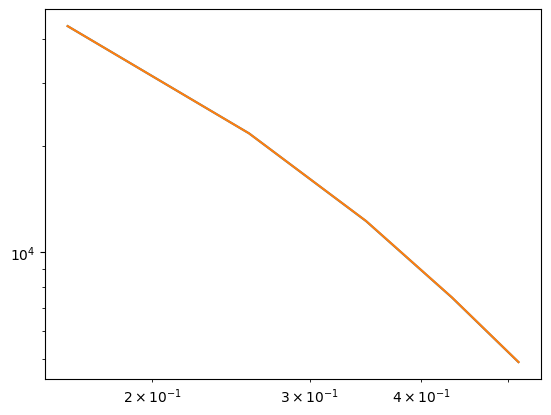

In [24]:
plt.loglog(fftpower.power["k"], np.real(fftpower.power["power"]) - fftpower.attrs["shotnoise"])
plt.loglog(fftpower_cpu.power["k"], np.real(fftpower_cpu.power["Pk"]) - fftpower_cpu.attrs["shotnoise"])

### 测试：ctypes 调用C动态链接库

In [1]:
import numpy as np 
import ctypes

from LSS_python.mesh import Mesh 

In [2]:
mesh_lib = ctypes.CDLL("../src/LSS_python/CPP/lib/mesh_clang.cpython-312-x86_64-linux-gnu.so")

In [3]:
test_array = np.array([1.1, 3.4, 5.2, 5.3], dtype=np.float32)
test_array_ptr = test_array.ctypes.data_as(ctypes.c_char_p)
n = test_array.shape[0]
_ =mesh_lib.test(test_array_ptr, n)

(1.100, 3.400, 5.200, 5.300)


In [4]:
_ = mesh_lib.test(ctypes.POINTER(ctypes.c_float)(), 7)

array is null


In [3]:
data = np.load("/DataGpu01/xiaoliang/snap100_shiftz.npy", mmap_mode="r")
# data = np.load("/Raid6/1/xiaoliang/AP_SysTest/data/11_nbar1e-3.shiftz.numNB30.npy", mmap_mode="r")

In [4]:
pos_float = np.copy(data["Position"].astype(np.float32))
# pos_float = np.copy(data[:,:3].astype(np.float32))

In [5]:
print(pos_float.shape)
print(pos_float.strides)

(519361057, 3)
(12, 4)


In [6]:
boxsize = np.array([1000.0] * 3, dtype=np.float32)
ngrids = np.array([256] * 3, dtype=np.uint64)
field = np.zeros(ngrids, dtype=np.float32)
print("Created field")

pos_ptr = pos_float.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
field_ptr = field.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
boxsize_ptr = boxsize.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
ngrids_ptr = ngrids.ctypes.data_as(ctypes.POINTER(ctypes.c_uint64))
nparticle = pos_float.shape[0]
nullptr = ctypes.POINTER(ctypes.c_float)()
nthreads = 5

_ = mesh_lib.run_cic_float(pos_ptr, field_ptr, nparticle, boxsize_ptr, ngrids_ptr, nullptr, nullptr, nthreads)

Created field
ngrids = (256, 256, 256)
Running CIC with 519361057 particles


In [7]:
np.sum(field)

np.float32(519361120.0)

### 测试：函数调用

#### Mesh 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
from scipy.fft import rfftn
from LSS_python.mesh import Mesh 

In [3]:
pos = np.load("/Raid6/1/xiaoliang/AP_SysTest/data/11_nbar1e-3.shiftz.numNB30.npy")[:,:3].astype(np.float32)

In [4]:
Nmesh = 256 
BoxSize = 2500.0
mesh_lss_c = Mesh(Nmesh, BoxSize)
mesh_lss_numba = Mesh(Nmesh, BoxSize)

In [11]:
mesh_lss_c.to_mesh(pos, resampler="CIC", interlaced=True, nthreads=5, is_norm=False, c_api=True)
mesh_lss_c.r2c(compensated=True, nthreads=5, c_api=True)

In [12]:
mesh_lss_numba.to_mesh(pos, resampler="CIC", interlaced=False, is_norm=False, c_api=False)
mesh_lss_numba.r2c(compensated=True, nthreads=5, c_api=False)

In [13]:
mesh_lss_c.complex_field[5,5,:5]

array([ 0.00205896-1.9890306e-04j,  0.00172993+1.5674659e-05j,
       -0.00122965-1.9651160e-03j, -0.00050939-2.4040397e-03j,
        0.00212777-1.2371904e-04j], dtype=complex64)

In [14]:
mesh_lss_numba.complex_field[5,5,:5]

array([ 0.00191942-1.8546650e-04j,  0.00161302+1.4756280e-05j,
       -0.00114638-1.8320468e-03j, -0.00047472-2.2414110e-03j,
        0.00198388-1.1551588e-04j], dtype=complex64)

#### FFTPower 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
from LSS_python.mesh import Mesh 
from LSS_python.fftpower import FFTPower, deal_ps_3d

In [3]:
mesh_dir = "/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/mass_fftpower_mesh1024_all_complex"
mesh_numba = Mesh.load(mesh_dir, only_complex=True)
mesh_capi = Mesh.load(mesh_dir, only_complex=True)

In [4]:
ps_3d_numba = deal_ps_3d(mesh_numba.complex_field, None, np.prod(mesh_numba.attrs["BoxSize"]), shotnoise=mesh_numba.attrs["shotnoise"] * mesh_numba.attrs["num_per_cell"] ** 2, inplace=False, nthreads=5, c_api=False)

In [5]:
ps_3d_capi = deal_ps_3d(mesh_capi.complex_field, None, np.prod(mesh_capi.attrs["BoxSize"]), shotnoise=mesh_capi.attrs["shotnoise"] * mesh_numba.attrs["num_per_cell"] ** 2, inplace=False, nthreads=5, c_api=True)

In [6]:
ps_3d_numba[0,0,:10]

array([4.8648653e+05+0.j, 5.2089615e+01+0.j, 3.6580591e+00+0.j,
       2.7679503e+00+0.j, 2.3361475e+00+0.j, 4.9961193e+01+0.j,
       1.0806839e+01+0.j, 3.3126141e+01+0.j, 6.9203281e+00+0.j,
       7.7869120e+00+0.j], dtype=complex64)

In [7]:
ps_3d_capi[0,0,:10]

array([4.8648653e+05+0.j, 5.2089615e+01+0.j, 3.6580591e+00+0.j,
       2.7679503e+00+0.j, 2.3361475e+00+0.j, 4.9961197e+01+0.j,
       1.0806839e+01+0.j, 3.3126144e+01+0.j, 6.9203281e+00+0.j,
       7.7869115e+00+0.j], dtype=complex64)

In [8]:
Nmesh = mesh_numba.attrs["Nmesh"]
BoxSize = mesh_numba.attrs["BoxSize"]
fftpower_numba = FFTPower(Nmesh, BoxSize, shotnoise=0.0)
fftpower_capi = FFTPower(Nmesh, BoxSize, shotnoise=0.0)

In [9]:
kmin = 0.1 
kmax= 3.1 
Nmu = 50
dk = 0.01
power_numba = fftpower_numba.cal_ps_from_3d(ps_3d_numba, kmin=kmin, kmax=kmax, dk=dk, Nmu=Nmu, mode="2d", k_logarithmic=False, nthreads=5, c_api=False)

In [10]:
power_capi = fftpower_capi.cal_ps_from_3d(ps_3d_capi, kmin=kmin, kmax=kmax, dk=dk, Nmu=Nmu, mode="2d", k_logarithmic=False, nthreads=5, c_api=True)

In [14]:
power_numba["Pkmu"][5]

array([0.94539402+0.j, 0.89310384+0.j, 0.96289097+0.j, 0.92809019+0.j,
       1.10439451+0.j, 1.00398062+0.j, 1.21031755+0.j, 1.07297605+0.j,
       1.16515895+0.j, 1.02080716+0.j, 1.12905819+0.j, 0.98076254+0.j,
       1.17805456+0.j, 0.96827604+0.j, 1.08801642+0.j, 1.08218667+0.j,
       1.1705272 +0.j, 1.08730221+0.j, 1.31937436+0.j, 1.10684375+0.j,
       1.13811836+0.j, 1.05551084+0.j, 1.14771751+0.j, 1.47278728+0.j,
       1.15174343+0.j, 1.35556134+0.j, 1.23255957+0.j, 1.19702574+0.j,
       1.25489161+0.j, 1.28020698+0.j, 1.3418506 +0.j, 1.5706122 +0.j,
       1.62942973+0.j, 1.37424437+0.j, 1.8127427 +0.j, 1.52939451+0.j,
       1.44917663+0.j, 1.74063492+0.j, 1.5712493 +0.j, 1.79216489+0.j,
       1.97713902+0.j, 1.56396723+0.j, 1.52114994+0.j, 1.75650644+0.j,
       1.9785412 +0.j, 1.99901344+0.j, 1.58356372+0.j, 2.30024223+0.j,
       2.17303197+0.j, 2.21032498+0.j])

In [ ]:
power_capi["Pkmu"][5] 

array([0.94539403+0.j, 0.89310385+0.j, 0.96289097+0.j, 0.9280902 +0.j,
       1.10439451+0.j, 1.00398063+0.j, 1.21031755+0.j, 1.07297606+0.j,
       1.16515896+0.j, 1.02080716+0.j, 1.12905819+0.j, 0.98076254+0.j,
       1.17805456+0.j, 0.96827604+0.j, 1.08801642+0.j, 1.08218668+0.j,
       1.1705272 +0.j, 1.08730222+0.j, 1.31937435+0.j, 1.10684376+0.j,
       1.13811836+0.j, 1.05551085+0.j, 1.14771751+0.j, 1.47278728+0.j,
       1.15174343+0.j, 1.35556133+0.j, 1.23255957+0.j, 1.19702573+0.j,
       1.25489161+0.j, 1.28020697+0.j, 1.34185059+0.j, 1.57061219+0.j,
       1.62942972+0.j, 1.37424437+0.j, 1.81274269+0.j, 1.5293945 +0.j,
       1.44917662+0.j, 1.7406349 +0.j, 1.57124929+0.j, 1.79216486+0.j,
       1.977139  +0.j, 1.5639672 +0.j, 1.52114993+0.j, 1.75650643+0.j,
       1.97854116+0.j, 1.9990134 +0.j, 1.58356373+0.j, 2.30024219+0.j,
       2.17303193+0.j, 2.21032495+0.j])

In [17]:
np.nanmax(np.abs(power_numba["Pkmu"] - power_capi["Pkmu"]))

np.float64(1.293691722636936e-07)

In [22]:
fftpower_check = FFTPower.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/HI_fftpower_mesh1024_all_k0dot1to3dot1_dk0dot01_Nmu50.pkl")
power_check = fftpower_check.power

In [33]:
from LSS_python.base import cal_HI_factor

In [35]:
np.nanmax(np.abs(power_capi["Pkmu"] * cal_HI_factor(0.43183, 0.3111, 1000.0, 1024)**2 - power_check["Pkmu"]))

np.float64(7.927729438961251e-05)

#### CUDA

In [1]:
import numpy as np 
import cupy as cp
from LSS_python.mesh import Mesh 

In [2]:
pos = np.load("/Raid6/1/xiaoliang/AP_SysTest/data/11_nbar1e-3.shiftz.numNB30.npy")[:,:3].astype(np.float32)

In [3]:
Nmesh = 256 
BoxSize = 2500.0 
mesh_capi = Mesh(Nmesh, BoxSize)
mesh_cuda = Mesh(Nmesh, BoxSize)

In [4]:
mesh_capi.to_mesh(pos, resampler="PCS", interlaced=False, nthreads=5, c_api=True)
mesh_capi.r2c(compensated=True, nthreads=5, c_api=True)

In [5]:
mesh_cuda.to_mesh(pos, resampler="PCS", interlaced=False, device_id=0, c_api=False)
mesh_cuda.r2c(compensated=True, nthreads=5, device_id=0, c_api=False)

In [6]:
mesh_capi.complex_field[0,0,:10]

array([ 9.3231940e-01+0.0000000e+00j,  2.7702641e-04+1.5539962e-03j,
       -4.4221731e-04+7.6516188e-04j, -2.1066999e-03-1.7875092e-03j,
       -4.6989365e-04-3.5006937e-03j,  2.8842175e-03+1.6902977e-03j,
       -2.2860649e-03-2.6867748e-04j, -2.1156747e-04+1.8730070e-03j,
       -1.5928647e-03+8.9567649e-05j,  3.2984782e-03-1.3068730e-03j],
      dtype=complex64)

In [7]:
mesh_cuda.complex_field_gpu[0,0,:10]

array([ 9.3231946e-01+0.0000000e+00j,  2.7702641e-04+1.5539962e-03j,
       -4.4221731e-04+7.6516176e-04j, -2.1067001e-03-1.7875091e-03j,
       -4.6989348e-04-3.5006932e-03j,  2.8842173e-03+1.6902976e-03j,
       -2.2860649e-03-2.6867748e-04j, -2.1156744e-04+1.8730070e-03j,
       -1.5928647e-03+8.9567606e-05j,  3.2984777e-03-1.3068729e-03j],
      dtype=complex64)

In [8]:
print(np.max(np.abs(np.real(mesh_capi.complex_field) - np.real(cp.asnumpy(mesh_cuda.complex_field_gpu)))))
print(np.max(np.abs(np.imag(mesh_capi.complex_field) - np.imag(cp.asnumpy(mesh_cuda.complex_field_gpu)))))

1.2852252e-07
3.6292477e-08


In [16]:
index_need = np.unravel_index(7215872, shape=mesh_capi.complex_field.shape)
print(index_need, mesh_capi.complex_field[index_need], mesh_cuda.complex_field_gpu[index_need])

(np.int64(218), np.int64(128), np.int64(128)) (1.1168326e-05-4.3684e-05j) (1.11684185e-05-4.368399e-05j)


### 全套

In [1]:
import numpy as np 
from LSS_python.mesh import Mesh 
from LSS_python.fftpower import FFTPower
from LSS_python.base import cal_HI_factor

In [2]:
data = np.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_shiftz_f4.npy")

In [3]:
pos = np.copy(data[:,:3])
mass = np.copy(data[:,3])

In [4]:
Nmesh = 1024 
BoxSize = 1000.0
mesh_capi = Mesh(Nmesh, BoxSize)
mesh_capi.to_mesh(pos, resampler="CIC", weights=mass, nthreads=10, c_api=True)

In [5]:
mesh_capi.r2c(compensated=True, nthreads=10)

In [6]:
mesh_check = Mesh.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/mass_fftpower_mesh1024_all_complex", only_complex=True)

In [7]:
mesh_check.complex_field[5,5,:10]

array([ 5.3793286e-05+2.2700004e-05j,  5.4236629e-05+1.3669823e-05j,
       -2.9358142e-05+2.1421762e-05j,  1.1304543e-04-9.2248329e-06j,
        1.2976332e-05-4.5433680e-05j, -1.7161864e-04-3.5145680e-05j,
        3.8566155e-05-7.4195763e-05j, -1.2243442e-05-8.1630562e-05j,
       -3.2641561e-05+5.9291629e-05j,  5.2525002e-06-7.1188108e-05j],
      dtype=complex64)

In [8]:
mesh_capi.complex_field[5,5,:10]

array([ 5.37932829e-05+2.2700006e-05j,  5.42366288e-05+1.3669823e-05j,
       -2.93581397e-05+2.1421760e-05j,  1.13045426e-04-9.2248301e-06j,
        1.29763339e-05-4.5433677e-05j, -1.71618638e-04-3.5145680e-05j,
        3.85661515e-05-7.4195756e-05j, -1.22434431e-05-8.1630555e-05j,
       -3.26415648e-05+5.9291626e-05j,  5.25250016e-06-7.1188108e-05j],
      dtype=complex64)

In [27]:
mesh_check.attrs

{'Nmesh': array([1024, 1024, 1024], dtype=int32),
 'BoxSize': array([1000., 1000., 1000.]),
 'resampler': None,
 'compensated': True,
 'interlaced': None,
 'N': 519361057,
 'W': np.float64(23682921.80616181),
 'W2': np.float64(6603410.613843589),
 'shotnoise': np.float64(11.773287278124606),
 'num_per_cell': np.float64(0.022056439710931675),
 'HI_factor': np.float64(22.72178861750707),
 'field_type': 'complex'}

In [28]:
mesh_capi.attrs

{'Nmesh': array([1024, 1024, 1024]),
 'BoxSize': array([1000., 1000., 1000.]),
 'resampler': 'CIC',
 'compensated': True,
 'interlaced': False,
 'is_norm': False,
 'N': 519361057,
 'W': np.float32(23682896.0),
 'W2': np.float32(6603419.5),
 'num_per_cell': np.float32(0.022056416),
 'shotnoise': np.float32(11.773329)}

In [9]:
fftpower = FFTPower(Nmesh=Nmesh, BoxSize=BoxSize, shotnoise=mesh_capi.attrs["shotnoise"] * mesh_capi.attrs["num_per_cell"] ** 2)

kmin = 0.1
kmax = 3.1 
dk = 0.01 
Nmu = 50
power_capi = fftpower.cal_ps_from_mesh(mesh_capi, kmin=kmin, kmax=kmax, dk=dk, Nmu=Nmu, mode="2d", k_logarithmic=False, ps_3d_inplace=False, nthreads=10, c_api=True)

In [41]:
power_capi["modes"]

array([[  180,     0,   192, ...,    80,   104,   148],
       [  164,     0,   344, ...,   184,   112,   108],
       [  216,     0,   432, ...,   112,   184,   170],
       ...,
       [94088, 98064, 96936, ..., 94360, 95688, 96066],
       [93668, 96464, 98576, ..., 96472, 95432, 95132],
       [92768, 99376, 97936, ..., 95800, 96560, 97050]], dtype=uint64)

In [10]:
fftpower_check = FFTPower.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/HI_fftpower_mesh1024_all_k0dot1to3dot1_dk0dot01_Nmu50.pkl")

In [3]:
fftpower_check.attrs

{'Nmesh': array([1024, 1024, 1024], dtype=int32),
 'BoxSize': array([1000., 1000., 1000.]),
 'shotnoise': 0.0,
 'kmin': 0.1,
 'kmax': 3.1,
 'dk': 0.01,
 'Nk': 299,
 'mode': '2d',
 'Nmu': 50}

In [13]:
fftpower_check.power["Pkmu"][5]

array([ 579.33647133+0.j,  547.2931047 +0.j,  590.05858809+0.j,
        568.7327065 +0.j,  676.77180879+0.j,  615.23827912+0.j,
        741.68133586+0.j,  657.51861164+0.j,  714.00819695+0.j,
        625.54956472+0.j,  691.88568816+0.j,  601.0102662 +0.j,
        721.91061122+0.j,  593.35854927+0.j,  666.73533513+0.j,
        663.1628646 +0.j,  717.29784994+0.j,  666.29766565+0.j,
        808.51123874+0.j,  678.27269991+0.j,  697.43775083+0.j,
        646.81594628+0.j,  703.32009818+0.j,  902.52251332+0.j,
        705.7871781 +0.j,  830.68658045+0.j,  755.31122679+0.j,
        733.53613062+0.j,  768.99627726+0.j,  784.5095083 +0.j,
        822.28465385+0.j,  962.46952809+0.j,  998.51284647+0.j,
        842.13552117+0.j, 1110.84684373+0.j,  937.21136509+0.j,
        888.05393569+0.j, 1066.65927209+0.j,  962.85993882+0.j,
       1098.23678109+0.j, 1211.58873983+0.j,  958.39749701+0.j,
        932.15910351+0.j, 1076.38532515+0.j, 1212.44799443+0.j,
       1224.9933592 +0.j,  970.40620453+

In [19]:
fftpower.power["Pkmu"][5] * cal_HI_factor(0.43183, 0.3111, 1000.0, 1024)**2 - fftpower.attrs["shotnoise"] * cal_HI_factor(0.43183, 0.3111, 1000.0, 1024)**2

array([ 579.336475  +0.j,  547.29309479+0.j,  590.05853544+0.j,
        568.73266087+0.j,  676.77172312+0.j,  615.23823667+0.j,
        741.68131739+0.j,  657.51864802+0.j,  714.00822451+0.j,
        625.54953828+0.j,  691.88564776+0.j,  601.01029618+0.j,
        721.91054971+0.j,  593.35858028+0.j,  666.73530977+0.j,
        663.16287803+0.j,  717.29789974+0.j,  666.29766378+0.j,
        808.51125684+0.j,  678.27267822+0.j,  697.43776111+0.j,
        646.81595688+0.j,  703.32010883+0.j,  902.52255066+0.j,
        705.78719721+0.j,  830.68664951+0.j,  755.31125685+0.j,
        733.53604112+0.j,  768.99627835+0.j,  784.5094623 +0.j,
        822.28467221+0.j,  962.46951332+0.j,  998.51276681+0.j,
        842.13553853+0.j, 1110.84691046+0.j,  937.21139951+0.j,
        888.05397368+0.j, 1066.65923163+0.j,  962.85988234+0.j,
       1098.23675993+0.j, 1211.58871581+0.j,  958.39749069+0.j,
        932.15911557+0.j, 1076.3853677 +0.j, 1212.44798414+0.j,
       1224.99330983+0.j,  970.4061199 +

In [18]:
fftpower.attrs["shotnoise"]

np.float32(0.0057275537)

### 研究：质量分配函数k空间核函数

In [6]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
H = 1000.0 / 1024 
k_N = np.pi / H 

In [114]:
n = np.arange(-50, 50, 1)
k = 1.5
p = 4
w_k = np.sinc((k + 2 * k_N * n) / 2.0/ k_N) ** p
print(np.sum(w_k**2))

if p == 1:
    print(1.0)
elif p == 2:
    print(1.0 - 2.0/3.0 * np.sin(np.pi * k / 2.0/ k_N)**2)
elif p == 3:
    print(1.0 - np.sin(np.pi * k / 2.0/ k_N)**2 + 2.0/15.0 * np.sin(np.pi * k / 2.0/ k_N)**4)
elif p == 4:
    print(1.0 - 4.0 / 3.0 * np.sin(np.pi * k / 2.0/ k_N)**2 + 6.0/15.0 * np.sin(np.pi * k / 2.0/ k_N)**4 - 4.0/315.0 * np.sin(np.pi * k / 2.0/ k_N)**6)
else:
    print("Not implemented")

0.48266872245689485
0.48266872245689446


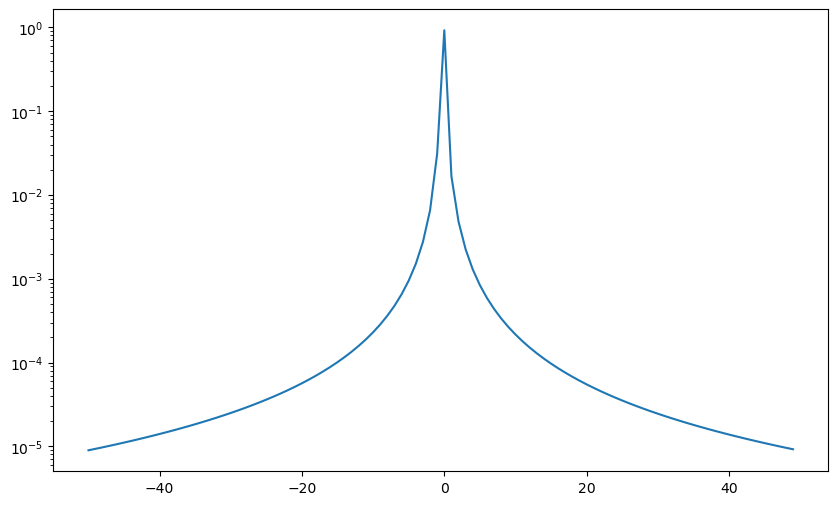

In [22]:
fig = plt.figure(dpi=100, figsize=(10,6))
plt.semilogy(n, w_k**2)
plt.show()

In [41]:
from scipy.optimize import curve_fit

In [117]:
k = np.linspace(0.0, 1.5, 1000)
n = np.arange(-10, 10, 1)
def sum_w(k):
    return np.array([np.sum([np.sinc((k_temp + 2 * k_N * n) / 2.0/ k_N) ** 10 for n in np.arange(-10, 10, 1)]) for k_temp in k])
def f(k, a, b, c, d):
    return 1.0 - a * np.sin(np.pi * k / 2.0/ k_N)**2 + b * np.sin(np.pi * k / 2.0/ k_N)**4 - c * np.sin(np.pi * k / 2.0/ k_N)**6 + d * np.sin(np.pi * k / 2.0/ k_N)**8

popt, pcov = curve_fit(f, k, sum_w(k), p0 = [1.0/3.0, 1.0/15.0, 1.0/35.0, 1.0/315.0])

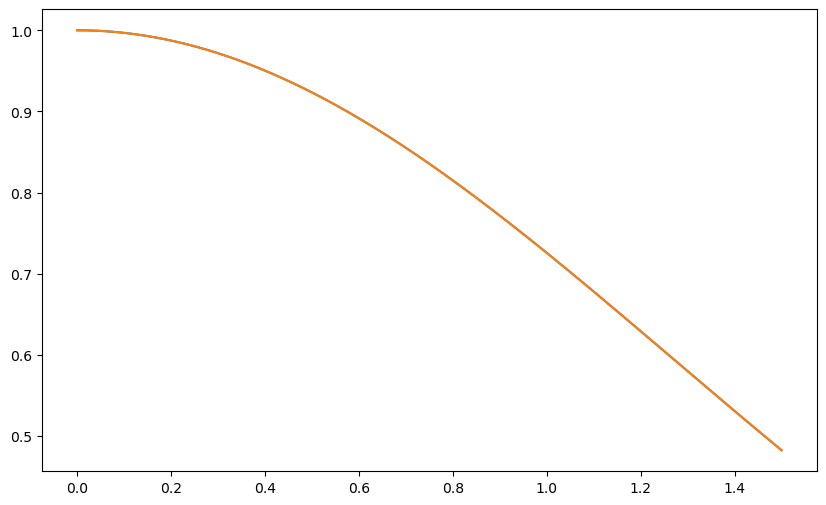

In [93]:
fig = plt.figure(dpi=100, figsize=(10,6))
plt.plot(k, f(k, 1.33333333, 0.4       , 0.01269841))
plt.plot(k, sum_w(k))
plt.show()

In [118]:
popt

array([1.66666667e+00, 7.77777778e-01, 8.99470899e-02, 7.05467372e-04])

In [130]:
popt[3] * 315

np.float64(0.22222222229967714)

In [88]:
sum_w([0.0,1.0])

np.float64(1.7258184765419742)